# Coarse-grain a simple transition matrix

To illustrate the application of *pyGPCCA* we will coarse-grain a simple irreducible transition matrix $P$ as a toy example. 

Firstly, we will import needed packages like ``numpy``, ``matplotlib`` and of course ``pygpcca``:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygpcca as gp

Next, we define a simple $12 \times 12$ row-stochastic (meaning that the rows of $P$ each sum up to one) transition matrix $P$ and plot it:

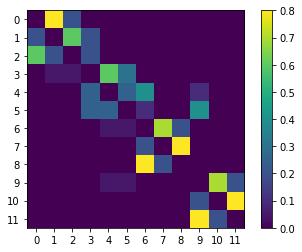

In [24]:
P = np.array(
    [
    # 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   10.  11.   
    [0.0, 0.8, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #0
    [0.2, 0.0, 0.6, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #1
    [0.6, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #2
    
    [0.0, 0.05, 0.05, 0.0, 0.6, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #3
    [0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.4, 0.0, 0.0, 0.1, 0.0, 0.0], #4
    [0.0, 0.0, 0.0, 0.25, 0.25, 0.0, 0.1, 0.0, 0.0, 0.4, 0.0, 0.0], #5
    
    [0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.0, 0.7, 0.2, 0.0, 0.0, 0.0], #6
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.8, 0.0, 0.0, 0.0], #7
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.2, 0.0, 0.0, 0.0, 0.0], #8
    
    [0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2], #9
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.8], #10
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.2, 0.0], #11
    ],
    dtype=np.float64,
)

# plot the matrix P:
fig, ax = plt.subplots()
c = ax.imshow(P)
plt.xticks(np.arange(P.shape[1]))
plt.yticks(np.arange(P.shape[0]))
plt.ylim(-0.5, P.shape[0]-0.5)
ax.set_ylim(ax.get_ylim()[::-1])
fig.colorbar(c)
plt.show()

Following this, we initialize a *GPCCA* object from the transition matrix $P$:

In [3]:
gpcca = gp.GPCCA(P, z='LM', method='brandts')

GPCCA is a spectral clustering method with optimized memberships.
It clusters the dominant $m$ Schur vectors of a transition matrix.
This algorithm generates a fuzzy clustering such that the resulting membership functions are as crisp (characteristic) as possible.

The parameter `z` specifies which portion of the eigenvalue spectrum of $P$ is to be sought. The returned invariant subspace of $P$ will be associated with this part of the spectrum.

In case of `z='LM'`, the eigenvalues with the largest magnitude will be sorted to the top in descending order.
This way the dominant (top) eigenvalues will be located near the unit circle in the complex plane, unraveling not only stable or metastable states, but cyclic states that are associated with eigenvalues near the roots of unity as well.

In case of `z='LR'`, the eigenvalues with the largest real part will be sorted to the top in descending order.
Thus stable and metastable states near the Perron root 1 are selected.

The parameter `method` specifies which method will be used to determine the invariant subspace.

If `method='brandts'`, a full Schur decomposition of $P$ utilizing
`scipy.linalg.schur` is performed and afterwards the returned Schur form $R$ and Schur vector matrix $Q$ are partially sorted to gain an orthonormal basis of the subspace associated with the $m$ dominant eigenvalues of $P$.
This is well tested and thus the default method, although it is also the slowest choice.

If `method='krylov'`, an orthonormal basis of the subspace associated with the $m$ dominant eigenvalues of $P$ is calculated using the Krylov-Schur method as implemented in SLEPc.
This is the fastest choice and especially suitable for very large $P$, but it is still experimental.

Afterwards, we can get a list of $minChi$ values for numbers of macrostates $m$ in an interval $[2, 12]$ of possible $m$ ($m=1$ is illegal here, since there is no point in clustering 12 microstates into one single macrostate). The $minChi$ values help us to determine an interval
$[m_{min}, m_{max}]$ of nearly optimal numbers of macrostates for clustering:

In [4]:
gpcca.minChi(2, 12)

[-1.6653345369377348e-16,
 -2.255418698866725e-16,
 -0.9923508699724691,
 -0.9972757370249341,
 -0.926802576904497,
 -0.2705117206956666,
 -0.3360447945215935,
 -0.2973036186306221,
 -0.29104047575515346,
 -0.42902208201892694,
 -3.5809019888001215e-16]

The $minChi$ criterion states that cluster numbers $m$ (i.e. clustering into $m$ clusters) with a $minChi$ value close to zero will potentially result in a optimal (meaning especially *crisp* or sharp) clustering.
Obviously, only $m=3$ qualifies as non-trivially potentially optimal, since for $m=2$ and $m=12$ always $minChi \approx 0$ trivially holds.

Now, we would optimize the clustering for numbers of macrostates $m$ in a selected interval $[m_{min}, m_{max}]$ of potentially optimal macrostate numbers to find the optimal number of macrostates $n_m$ resulting in the crispest clustering in the given interval.

Here, this interval would contain only $m=2,3$, since there is no benefit in clustering $n=12$ data points into $m=n$ clusters. 

Having said that, we here choose the whole interval $[2, 12]$ of legal cluster numbers to get a better impression of the spectrum associated with $P$ later, when looking at the eigenvalues of $P$:

In [5]:
gpcca.optimize({'m_min':2, 'm_max':12})

/home/breuter/g-pcca/pyGPCCA/pygpcca/_gpcca.py:999: UserWarning: Clustering into 4 clusters will split complex conjugate eigenvalues. Skipping clustering into 4 clusters.
  f"Clustering into {m} clusters will split complex conjugate eigenvalues. "
/home/breuter/g-pcca/pyGPCCA/pygpcca/_gpcca.py:999: UserWarning: Clustering into 6 clusters will split complex conjugate eigenvalues. Skipping clustering into 6 clusters.
  f"Clustering into {m} clusters will split complex conjugate eigenvalues. "
/home/breuter/g-pcca/pyGPCCA/pygpcca/_gpcca.py:999: UserWarning: Clustering into 9 clusters will split complex conjugate eigenvalues. Skipping clustering into 9 clusters.
  f"Clustering into {m} clusters will split complex conjugate eigenvalues. "
/home/breuter/g-pcca/pyGPCCA/pygpcca/_gpcca.py:1033: UserWarning: Clustering 12 data points into 12 clusters is always perfectly crisp. Thus m=12 won't be included in the search for the optimal cluster number.
  f"Clustering {n} data points into {max(m_lis

The optimized *GPCCA* object is returned above and we can now access different properties of it. 

Note: *pyGPCCA* warns that clustering $P$ into 4, 6, and 9 clusters would split complex conjugate eigenvalues and thus skips the optimization for those cluster numbers.
Further, *pyGPCCA* warns that Clustering 12 data points into 12 clusters is always perfectly crisp, i.e. $\xi \approx 1$. Thus m=12 won't be included in the search for the optimal cluster number, since it will always be selected to be optimal despite there is no benefit from clustering $n=12$ data points into $m=n$ clusters.

The crispness values $\xi \in [0,1]$ for numbers of macrostates $m$ in the selected interval $[m_{min}, m_{max}]$ can be accessed via:

In [6]:
gpcca.crispness_values

array([0.74151472, 0.81512805, 0.        , 0.38587154, 0.        ,
       0.41628049, 0.41788963, 0.        , 0.55513151, 0.53758366,
       1.        ])

The crispness $\xi \in [0, 1]$ quantifies the optimality of a clustering (higher is better). It characterizes how crisp (sharp) the decomposition of the state space into $m$ clusters is.
Since $m=4,6,9$ were skipped, the associated crispness values are assigned to zero, because no clustering was performed.

The optimal crispness for the optimal number of macrostates $n_m$ in the selected interval $[m_{min}, m_{max}]$ can be accessed via:

In [7]:
gpcca.optimal_crispness

0.8151280474517894

The optimal number of macrostates $n_m$ can be accessed via:

In [8]:
gpcca.n_m

3

The optimal number of clusters or macrostates $n_m$ is the cluster number $m$ with the maximum crispness.

A vector containing the top $m_{max}$ eigenvalues of $P$ can be accessed via (here we get the full sorted spectrum of $P$, since we chose $m_{max}=n$):

In [10]:
gpcca.top_eigenvalues

array([ 1.        +0.j        ,  0.96554293+0.j        ,
        0.88404279+0.j        , -0.48277146+0.48908574j,
       -0.48277146-0.48908574j, -0.49366905+0.47392788j,
       -0.49366905-0.47392788j,  0.58853656+0.j        ,
       -0.43198962+0.39030468j, -0.43198962-0.39030468j,
       -0.37126202+0.j        , -0.25      +0.j        ])

A vector containing the dominant $n_m$ eigenvalues of $P$ can be accessed via:

In [11]:
gpcca.dominant_eigenvalues

array([1.        +0.j, 0.96554293+0.j, 0.88404279+0.j])

An array $\chi$ containing the membership $\chi_{ij}$ (or probability)
of each microstate $i$ (to be assigned) to each cluster or macrostate $j$ is available via:

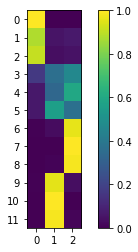

array([[1.00000000e+00, 0.00000000e+00, 8.44548736e-18],
       [8.80009662e-01, 5.26338400e-02, 6.73564979e-02],
       [9.12351139e-01, 3.84758290e-02, 4.91730323e-02],
       [1.64953404e-01, 3.67067094e-01, 4.67979502e-01],
       [6.51588802e-02, 3.35927186e-01, 5.98913934e-01],
       [6.51588802e-02, 5.64708356e-01, 3.70132763e-01],
       [5.02066367e-03, 3.27724659e-02, 9.62206870e-01],
       [1.27462550e-16, 1.83492669e-16, 1.00000000e+00],
       [1.78878958e-03, 1.11025375e-02, 9.87108673e-01],
       [5.02066367e-03, 9.59750248e-01, 3.52290885e-02],
       [0.00000000e+00, 1.00000000e+00, 2.42354345e-17],
       [1.78878958e-03, 9.86286754e-01, 1.19244563e-02]])

In [25]:
chi = gpcca.memberships
# plot chi:
fig, ax = plt.subplots()
c = ax.imshow(chi)
plt.xticks(np.arange(chi.shape[1]))
plt.yticks(np.arange(chi.shape[0]))
plt.ylim(-0.5, chi.shape[0]-0.5)
ax.set_ylim(ax.get_ylim()[::-1])
fig.colorbar(c)
plt.show()
# show chi matrix:
chi

The optimal coarse-grained transition matrix

$P_c = (\chi^T D \chi)^{-1} (\chi^T D P \chi)$

can be accessed via:

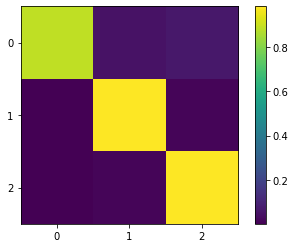

array([[0.88647796, 0.04980224, 0.0637198 ],
       [0.00243516, 0.98097945, 0.01658538],
       [0.00243516, 0.01543652, 0.98212831]])

In [26]:
P_c = gpcca.coarse_grained_transition_matrix
# plot P_c:
fig, ax = plt.subplots()
c = ax.imshow(P_c)
plt.xticks(np.arange(P_c.shape[1]))
plt.yticks(np.arange(P_c.shape[0]))
plt.ylim(-0.5, P_c.shape[0]-0.5)
ax.set_ylim(ax.get_ylim()[::-1])
fig.colorbar(c)
plt.show()
# show P_c matrix:
P_c

There are many more properties that can be accessed as you can see in the API documentation [here](https://pygpcca.readthedocs.io/en/latest/api/pygpcca.GPCCA.html), e.g.:

The input probability distribution of the microstates:

In [14]:
gpcca.input_distribution

array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333])

The coarse grained input distribution of the macrostates:

In [15]:
gpcca.coarse_grained_input_distribution

array([0.25843757, 0.36239369, 0.37916873])

An integer vector containing the macrostate each microstate is located in
(This employs an absolute crisp clustering, e.g. $\chi_{ij} \in \{0,1\}$, and is recommended only for visualization purposes.
You *cannot* compute any actual quantity of the coarse-grained kinetics without employing the fuzzy memberships, e.g. $\chi_{ij} \in [0,1]$.):

In [16]:
gpcca.macrostate_assignment

array([0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 1, 1])

A list were each element is an array that contains the indices of microstates assigned to the respective (first, second, third, ...) macrostate (This employs an absolute crisp clustering, e.g. $\chi_{ij} \in \{0,1\}$, and is recommended only for visualization purposes.
You *cannot* compute any actual quantity of the coarse-grained kinetics without employing the fuzzy memberships, e.g. $\chi_{ij} \in [0,1]$.):

In [17]:
gpcca.macrostate_sets

[array([0, 1, 2]), array([ 5,  9, 10, 11]), array([3, 4, 6, 7, 8])]

The optimized rotation matrix, which rotates the dominant Schur vectors to yield the GPCCA memberships, i.e. $\chi = X A$:

In [18]:
gpcca.rotation_matrix

array([[ 0.25843757,  0.36239369,  0.37916873],
       [ 0.03366022, -0.36112468,  0.32746445],
       [-0.39024389,  0.164552  ,  0.22569189]])

Ordered top left part of the real Schur matrix $R$ of $P$.
The ordered partial real Schur matrix $R$ of $P$ fulfills $P Q = Q R$ with the ordered matrix of dominant Schur vectors $Q$:

In [20]:
gpcca.schur_matrix

array([[ 1.00000000e+00,  6.38159449e-04, -7.04970784e-02],
       [ 0.00000000e+00,  9.65542930e-01,  7.02973961e-03],
       [ 0.00000000e+00,  0.00000000e+00,  8.84042793e-01]])

Array $Q$ with the sorted Schur vectors in the columns
(The constant Schur vector is in the first column):

In [21]:
gpcca.schur_vectors

array([[ 1.        ,  0.14326506, -1.88789655],
       [ 1.        ,  0.13739019, -1.58092803],
       [ 1.        ,  0.13889124, -1.66367359],
       [ 1.        ,  0.10015109,  0.24819166],
       [ 1.        ,  0.31120067,  0.52211907],
       [ 1.        , -0.34824151,  0.46523933],
       [ 1.        ,  1.25811096,  0.75789837],
       [ 1.        ,  1.35867697,  0.77943807],
       [ 1.        ,  1.32450074,  0.77190645],
       [ 1.        , -1.41382332,  0.52743247],
       [ 1.        , -1.52373762,  0.53081733],
       [ 1.        , -1.48638447,  0.52945543]])

Stationary probability distribution $\pi$ of the microstates (a vector that sums to 1):

In [22]:
gpcca.stationary_probability

array([0.00356002, 0.00462803, 0.00439069, 0.01803744, 0.03463189,
       0.03030291, 0.16883048, 0.14873162, 0.15275139, 0.15584352,
       0.13729072, 0.14100128])

Coarse grained stationary distribution $\pi_c = \chi^T \pi$:

In [23]:
gpcca.coarse_grained_stationary_probability

array([0.02100054, 0.46893777, 0.51006168])